# Fast, tuned transport rules are sensitive to changes in the target distribution (*deterministic simulations*)

Summary of simulations:

* We consider an unbranched cable with $N$ compartments

* Each pair of microtubule transport rate constants, $a_i$ and $b_i$ (anterograde and retrograde, respectively), are constrained to sum to 1.

* The detachment/delivery rate constants for each compartment are denoted $c_i$. For simplicity, we assume that $c_i$ is proportional to the target steady-state distribution for compartment $i$ (see strategy 3 in figure 4B and 4D).

* We assume that there are some number of recently activated synapses distributed along the cable. The "target" steady-state distribution for the transported material is a sequence of double exponential curves, centered around each activated synapse.

* We consider the soma to be the left end of the cable, so all material is initially contained in this compartment.

* The results we highlight here are not sensitive to the total amount of cargo, $\sum_i u_i$, for this model

In [1]:
from __future__ import division
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import expm # matrix exponential solves linear system
import pylab as plt
from time import sleep
%matplotlib inline

# JSAnimation import available at https://github.com/jakevdp/JSAnimation
from JSAnimation import IPython_display
from matplotlib import animation

N = 100 # number of compartments
x = np.linspace(0,1,N) # position along cable
DC = 10 # diffusion coeff [microns^2 s^-1]
cs = 8  # microns

def get_matrix(n_syn,timescale,bias,syn_loc):
    """Calculates the state-transition matrix, A"""
    # Calculate target profile, y
    if syn_loc is None: syn_loc = np.linspace(0.1,0.9,n_syn)
    x = np.linspace(0,1,N)
    y = np.zeros(N)
    for i in syn_loc:
        y += 0.5*np.exp(-abs(x - x[int(i*N)])*100)
    
    # detachment rates
    c = timescale*y
    
    # trafficking rates, constrain so that a+b = 1
    a = np.linspace((DC/(cs**2)/2.)+bias,(DC/(cs**2)/2.),N-1)
    b = np.linspace((DC/(cs**2)/2.)-bias,(DC/(cs**2)/2.),N-1)
    
    mid = -c
    mid[:-1] -= a
    mid[1:]  -= b
    A1 = np.diag(a, -1) + np.diag(mid) + np.diag(b, 1) # Upper-right block
    A2 = np.diag(c) # Lower-left block
    
    # State-transition matrix
    A = np.array(np.bmat([[A1,np.zeros((N,N))],[A2,np.zeros((N,N))]]))
    
    # initial condition
    u0 = np.zeros(2*N)
    u0[0] = np.sum(y)
    
    return A,u0,y

def run_sim(n_syn,timescale=1e-4,bias=0.0,syn_loc=None):
    A,u0,y = get_matrix(n_syn,timescale,bias,syn_loc)
    
    # time axis
    nt = 40
    t = np.logspace(-np.log10(timescale)-2,-np.log10(timescale)+3,nt)
    
    # animation figure
    fig = plt.figure()
    ax1 = plt.subplot(2,1,1)
    plt.title('concentration on microtubule')
    line1, = ax1.plot([],[],lw=2)
    plt.ylim([-0.02,0.2]),plt.xlim([0,1])
    ax2 = plt.subplot(2,1,2)
    plt.title('detached concentration')
    line2, = ax2.plot([],[],lw=2)
    plt.ylim([-0.02,1.0]),plt.xlim([0,1])
    plt.tight_layout()

    def init():
        line1.set_data(x, u0[:N])
        line2.set_data(x, u0[N:])
        return line1,line2,

    def animate(i):
        u = np.dot(expm(A*t[i]),u0)
        line1.set_data(x, u[:N])
        line2.set_data(x, u[N:])
        ax1.set_title('concentration on microtubule: '+str(np.round(t[i]/60))+' mins')
        return line1,line2,
    
    return fig,animate,init,nt

def save_steady_state(filename,n_syn,timescale=1e-4,bias=0.0,syn_loc=None):
    A,u0,y = get_matrix(n_syn,timescale,bias,syn_loc)
    tss = 10**(-np.log10(timescale)+4)
    uss = np.dot(expm(A*tss),u0) # steady-state profile
    
    plt.figure()
    plt.title('steady-state concentration')
    plt.plot(x,y,'-k',lw=2)
    plt.plot(x,uss[N:],'-r',lw=2)
    plt.ylim([-0.02,1.3]),plt.xlim([0,1])
    plt.legend(('target','steady-state'))
    plt.tight_layout()
    plt.savefig(filename+'.svg')

def calc_tradeoff_curve(n_syn,bias=0.0,syn_loc=None):
    tau,err = [],[]
    for timescale in np.logspace(-4,-0.9,30):
        A,u0,y = get_matrix(n_syn,timescale,bias,syn_loc)
        tss = calc_timescale(A)
        uss = np.dot(expm(A*1e2*tss),u0) # steady-state profile
        err.append(100*np.mean(np.abs((y-uss[N:])/y)))
        tau.append(tss)
    return np.array(tau),np.array(err)

def calc_timescale(A,perc_error=0.05,tol=1.0):
    # calculate number of seconds to reach steady-state (within perc_error)
    u0 = np.ones(N*2)
    u0[0] = 1.0
    
    upper_bound = 1e10
    lower_bound = 0
    while (upper_bound-lower_bound)>tol:
        tt = lower_bound + (upper_bound-lower_bound)/2
        u = np.dot(expm(A*tt),u0)
        if np.sum(u[:N]) > perc_error:
            # not converged to steady-state
            lower_bound = tt
        else:
            # converged to steady-state
            upper_bound = tt
    return lower_bound + (upper_bound-lower_bound)/2

### Precise, flexible, but slow trafficking

If the timescale of transport is much faster than the timescale of detachment/delivery, the trafficking process is slow but very flexible and precise. See figure 4 in the main paper. The animation below shows the distribution of material along the microtubules (top subplot) and delivered to the synapses (bottom subplot). For this demonstration we assume there are 6 evenly spaced synaptic sites along the cable.


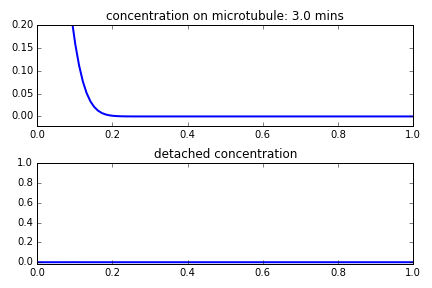
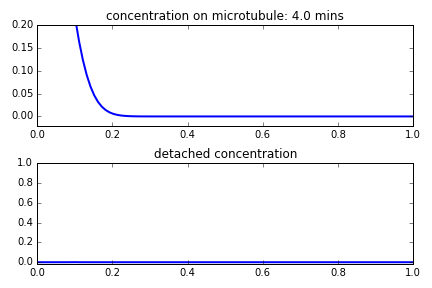
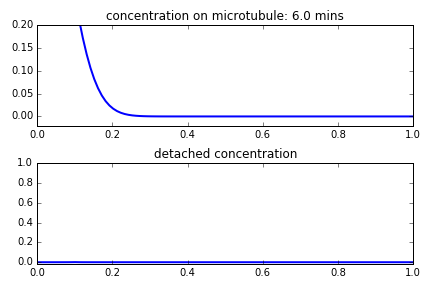
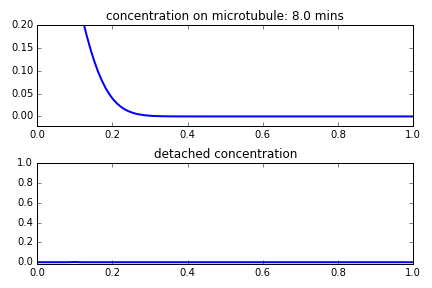
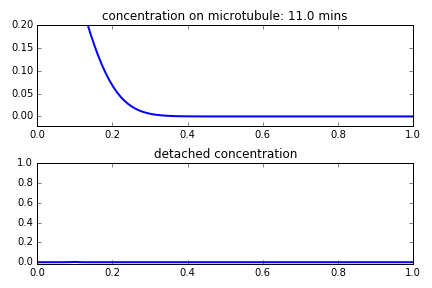
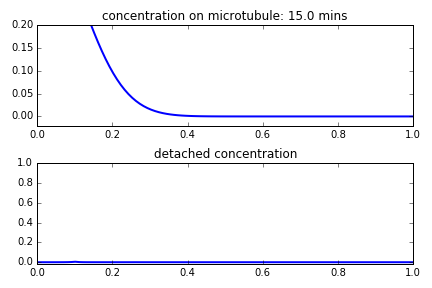
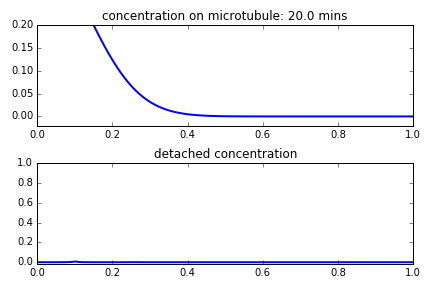
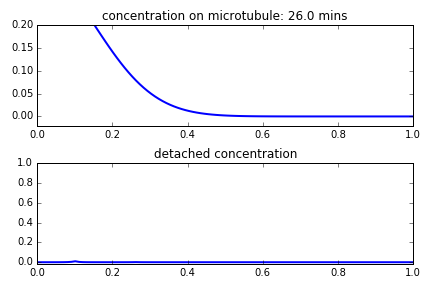
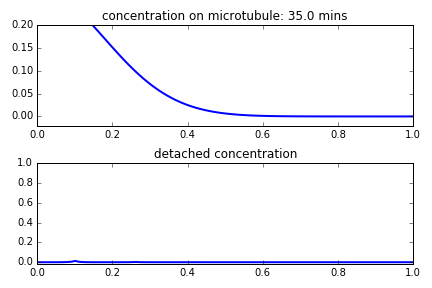
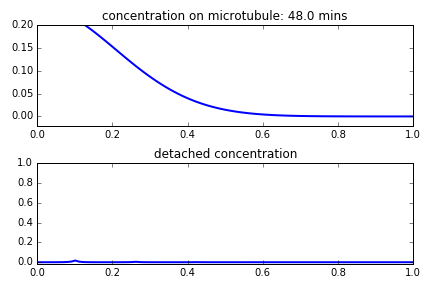
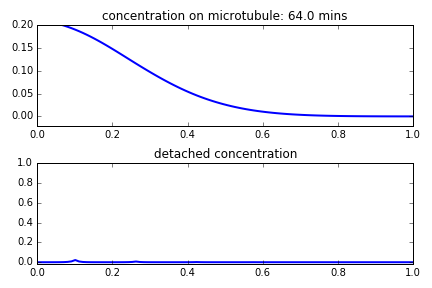
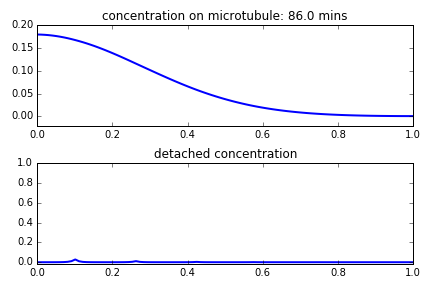
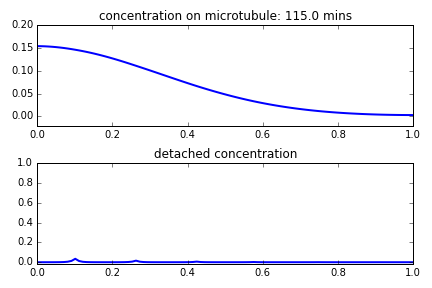
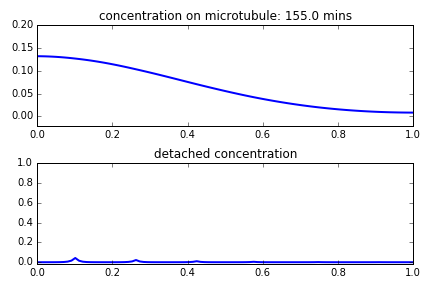
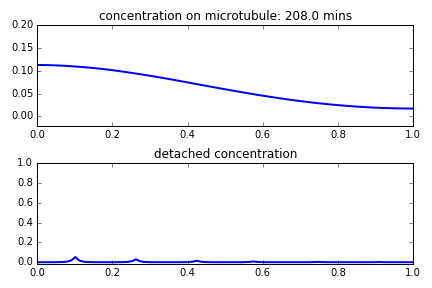
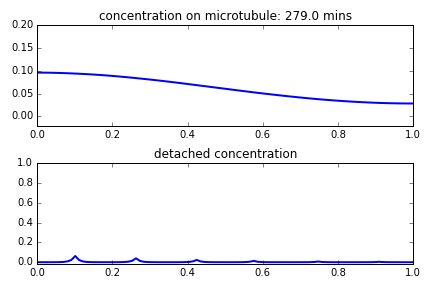
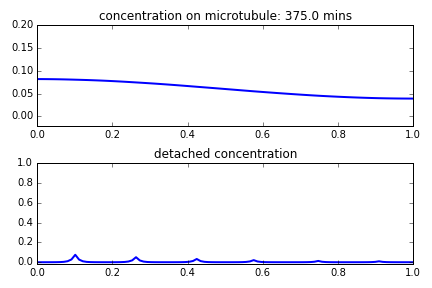
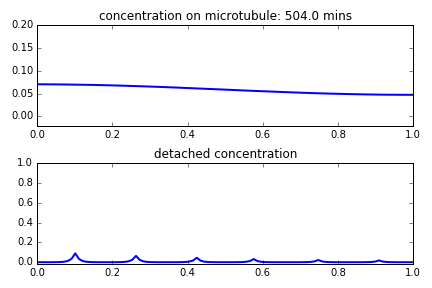
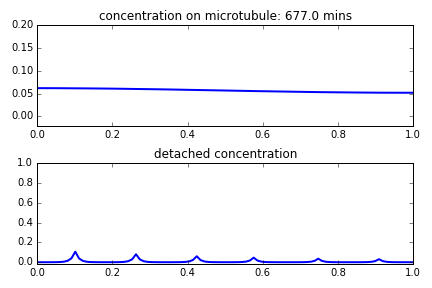
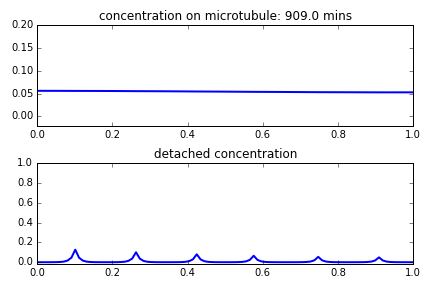
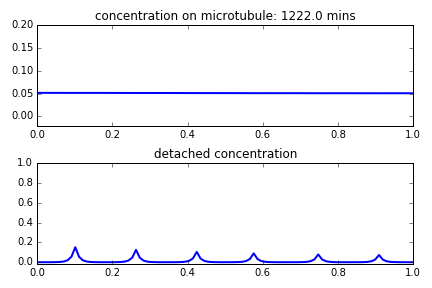
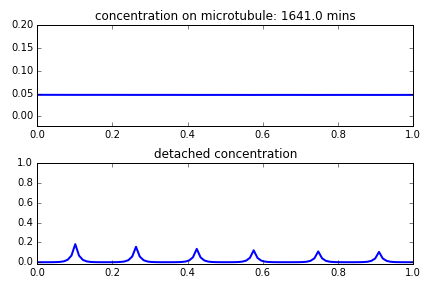
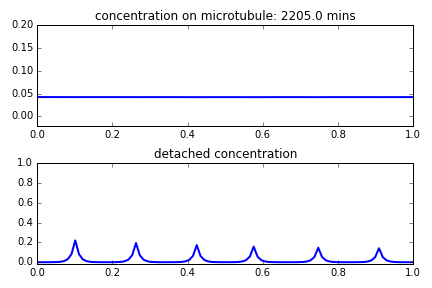
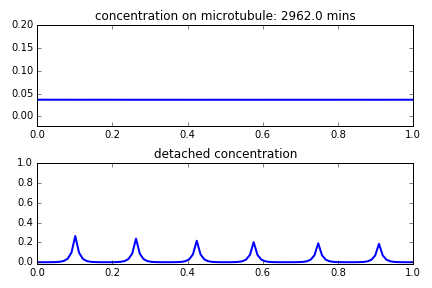
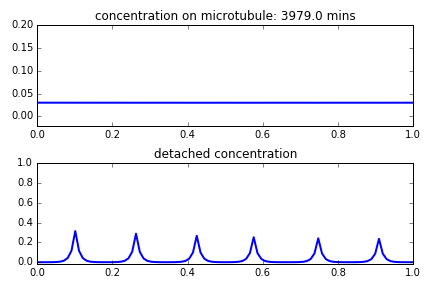
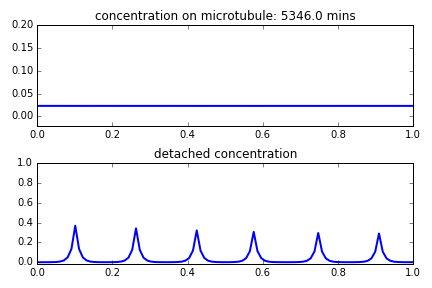
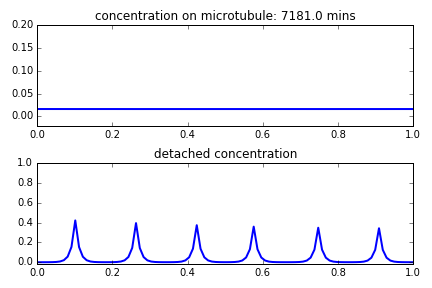
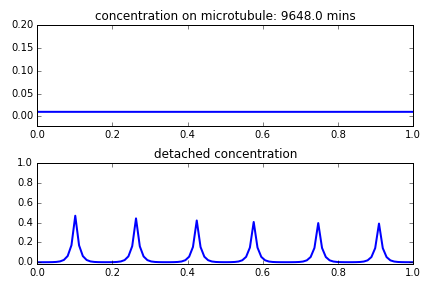
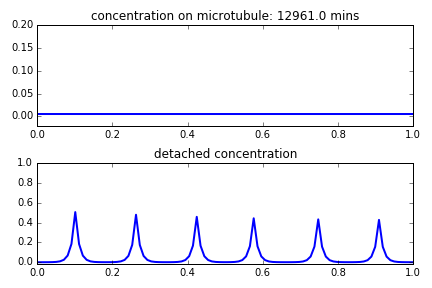
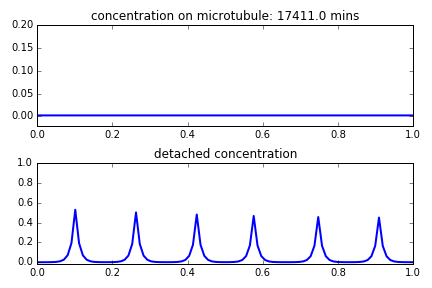
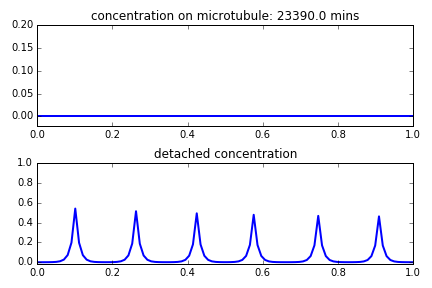
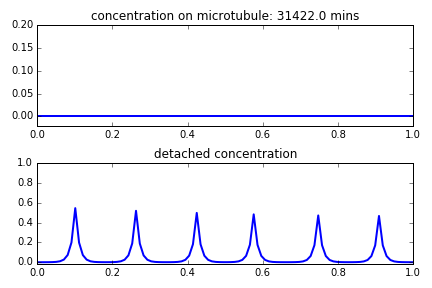
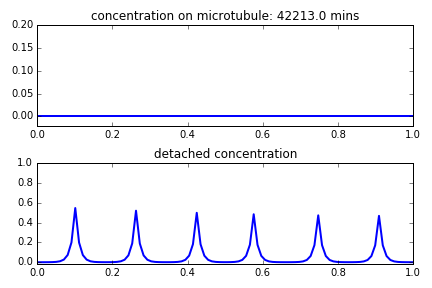
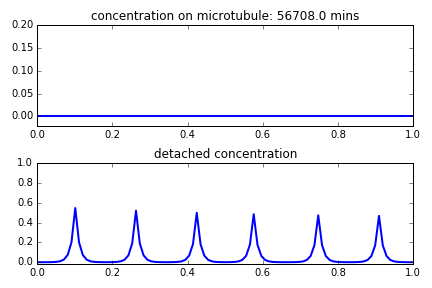
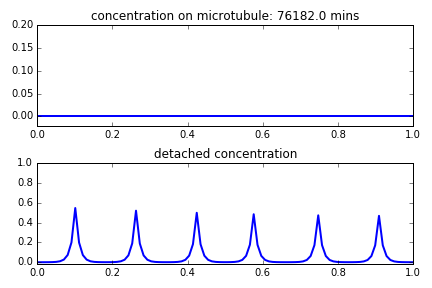
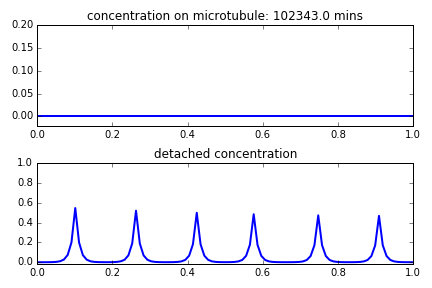
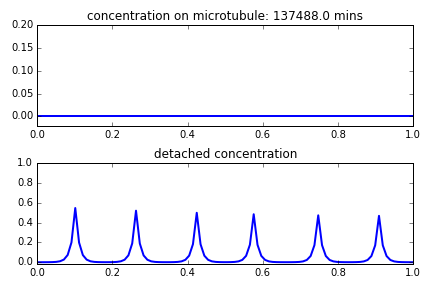
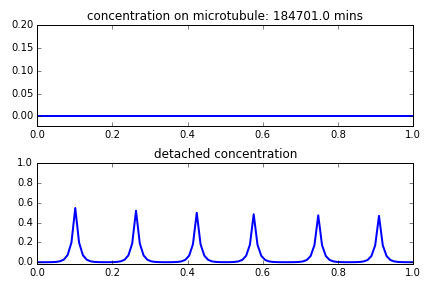
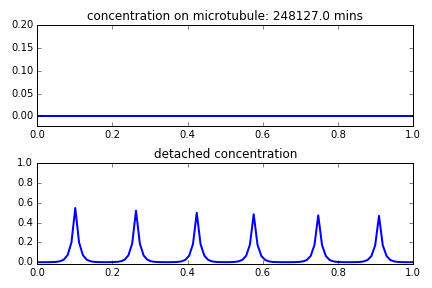
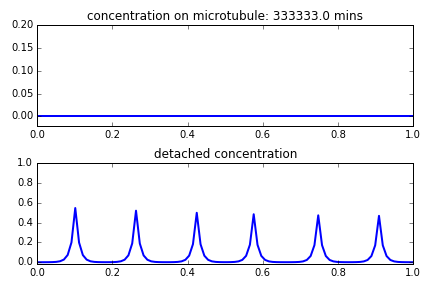

In [2]:
fig,animate,init,nt = run_sim(6,timescale=5e-5)
ani1 = animation.FuncAnimation(fig, animate, init_func=init, frames=nt, interval=100)
ani1.save('01.mp4'); ani1

### Fast, naïve transport scheme leads to proximal bias

This is the same phenomenon shown in Figure 5B and 5D, and occurs when the detachment/delivery rate constants, $c_i$, are not sufficiently slower than the transport rate constants.


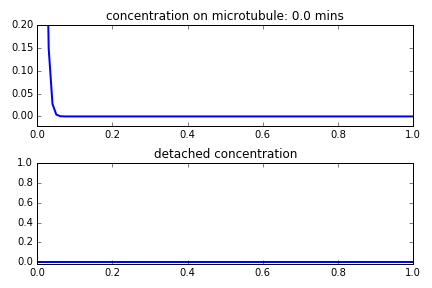
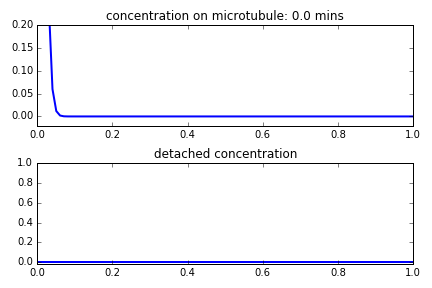
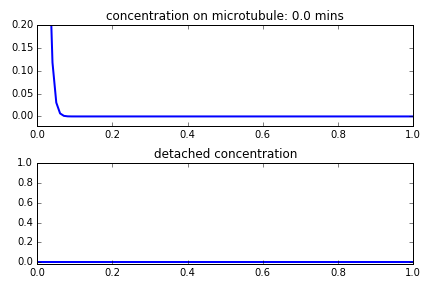
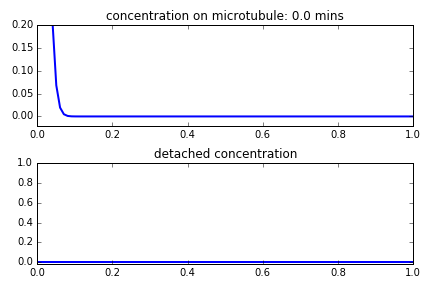
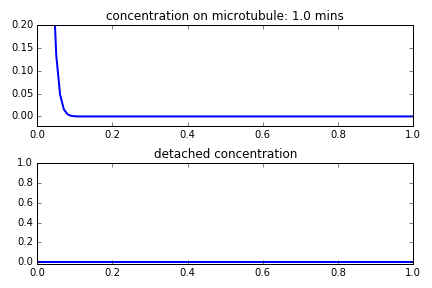
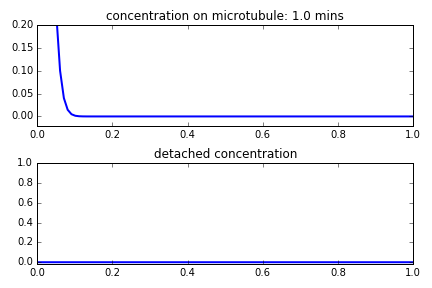
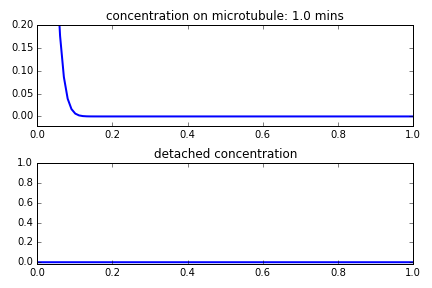
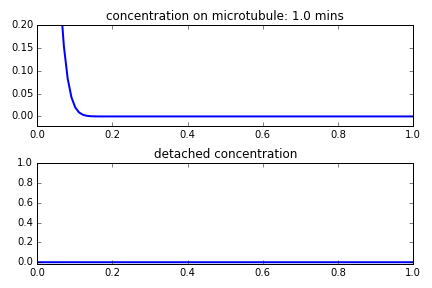
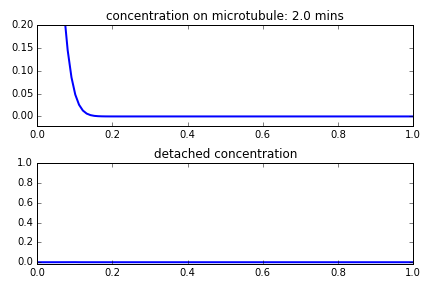
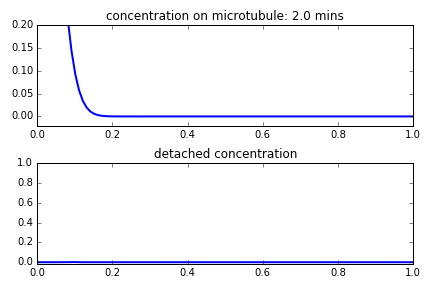
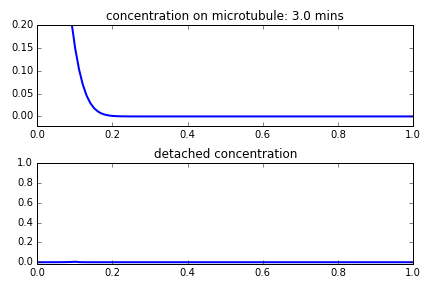
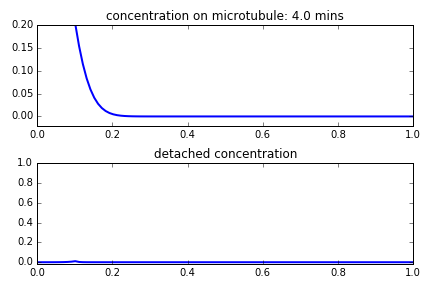
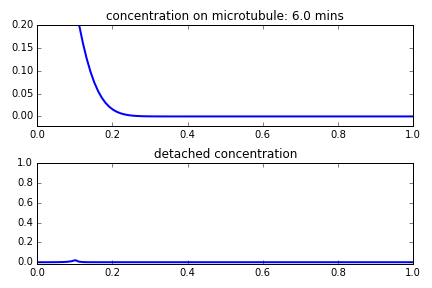
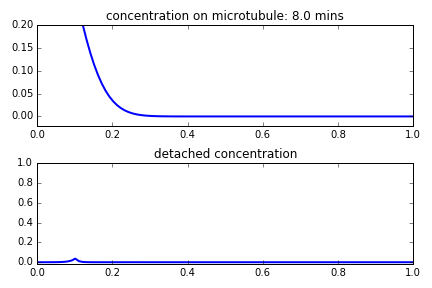
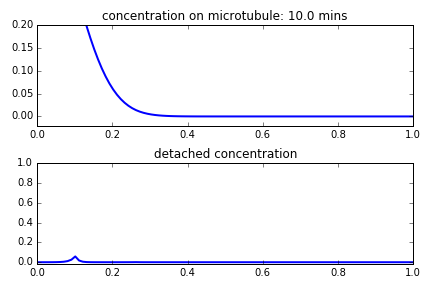
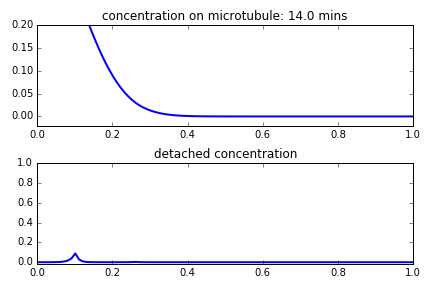
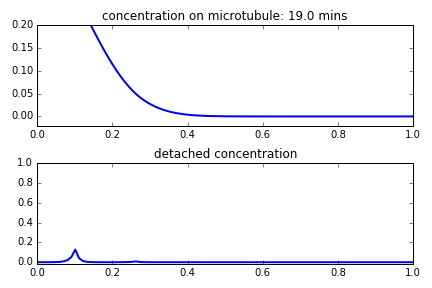
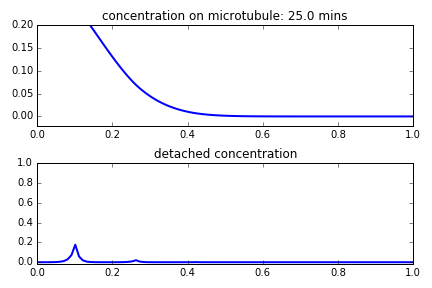
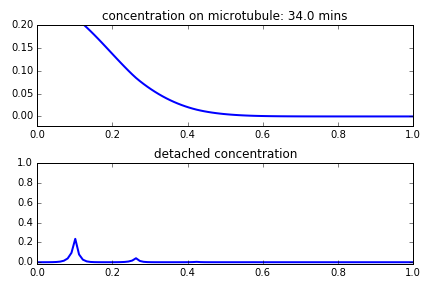
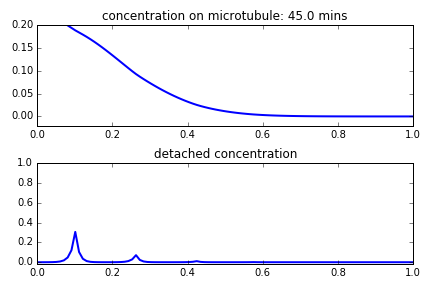
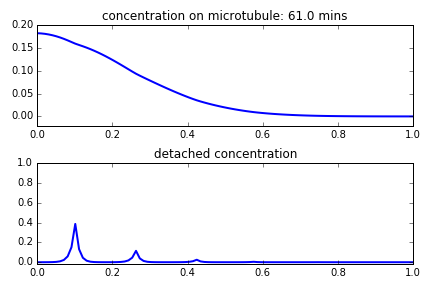
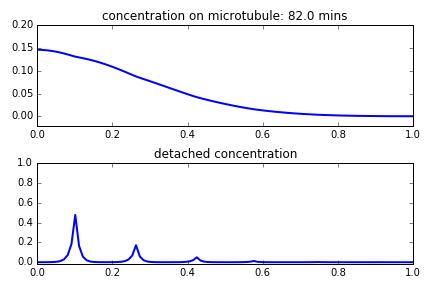
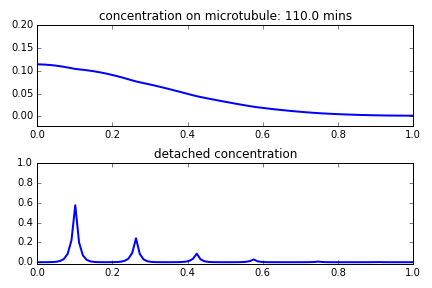
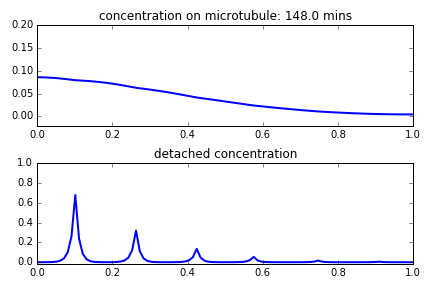
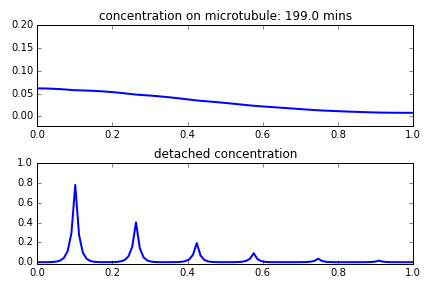
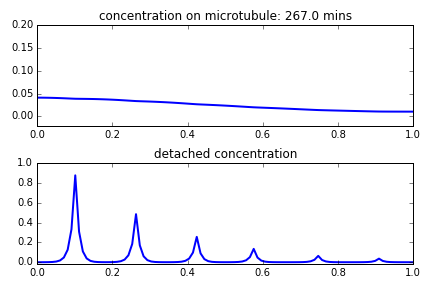
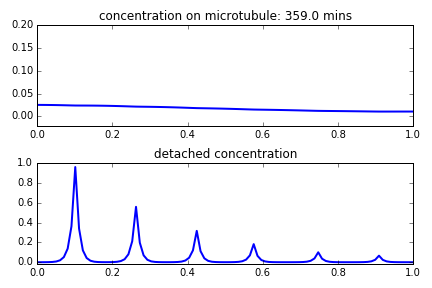
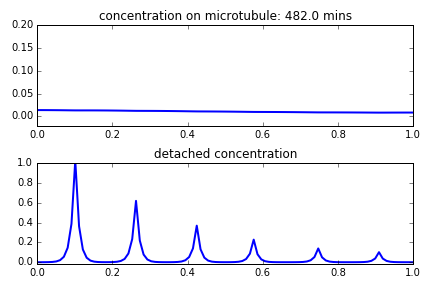
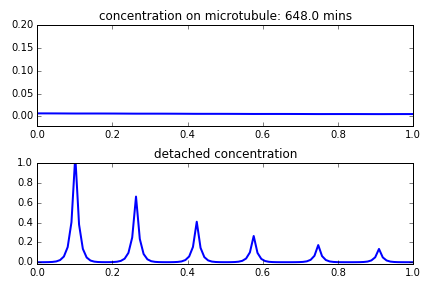
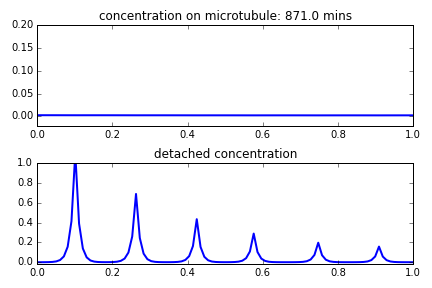
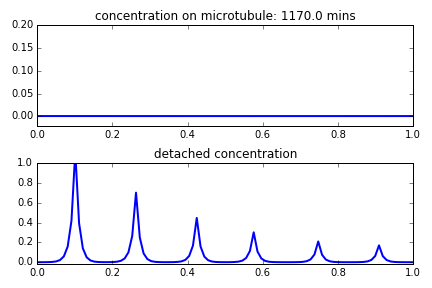
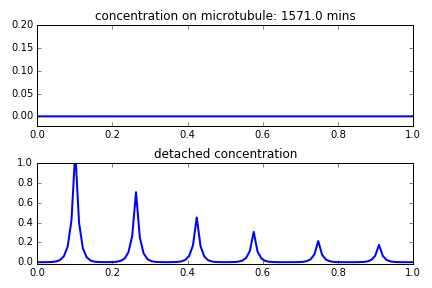
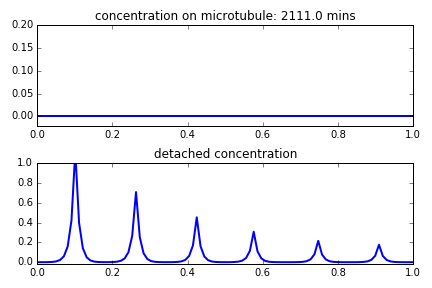
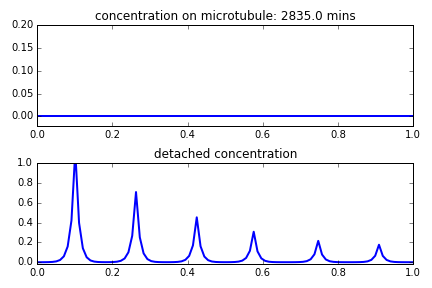
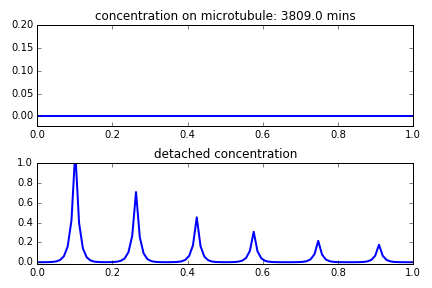
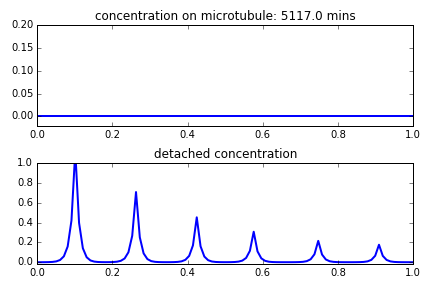
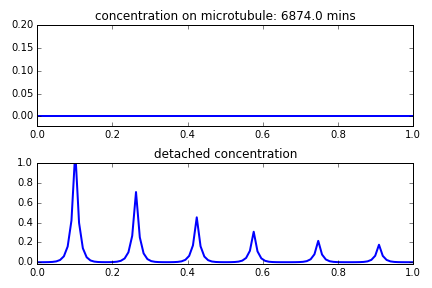
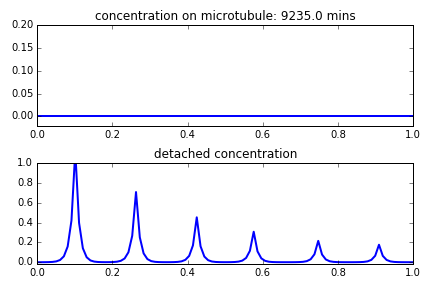
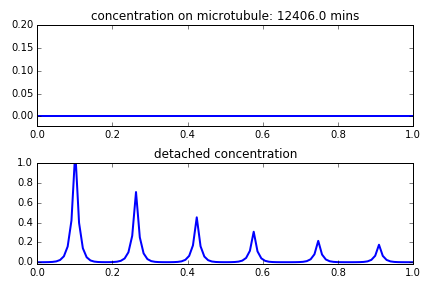
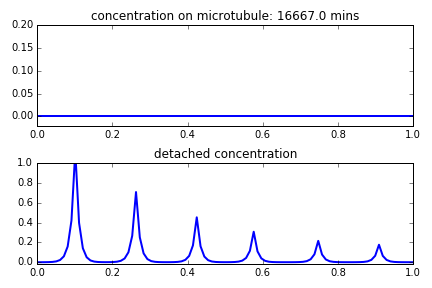

In [3]:
fig,animate,init,nt = run_sim(6,timescale=1e-3)
ani2 = animation.FuncAnimation(fig, animate, init_func=init, frames=nt, interval=100)
ani2.save('02.mp4'); ani2

### Can we tweak the transport parameters to improve this? Yes, but at a cost.

To counteract the proximal bias shown in the animation above, we add a bias to the anterograde rate constants ($a_i$) on the left side of the cable. Specifically, we set `a = linspace(0.5+bias,0.5,N)` and `b = linspace(0.5-bias,0.5,N)` so that `a[0] = 0.5+bias` and `b[0] = 0.5-bias` at the left end of the cable; `a[-1] = b[-1] = 0.5` at the right end of the cable. By tuning the `bias` parameter we can produce both fast and precise trafficking for the six evenly spaced synapses.


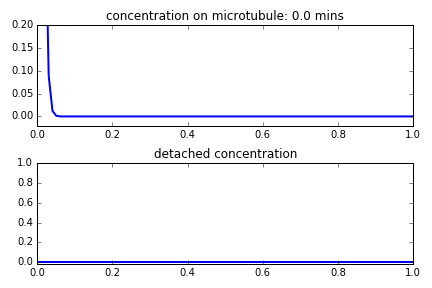
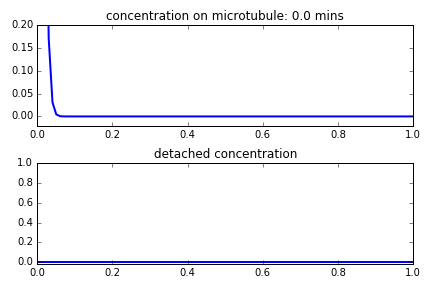
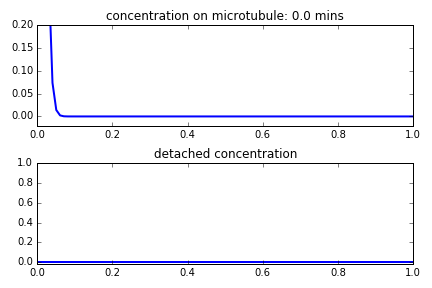
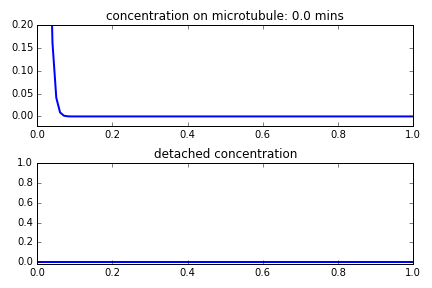
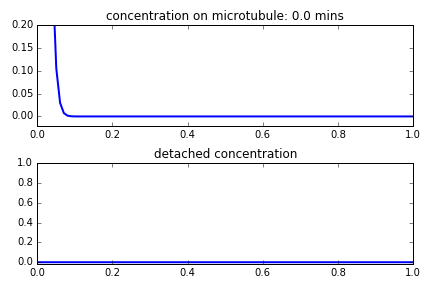
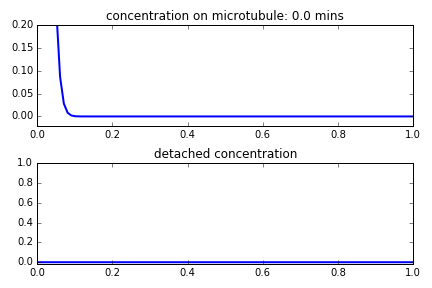
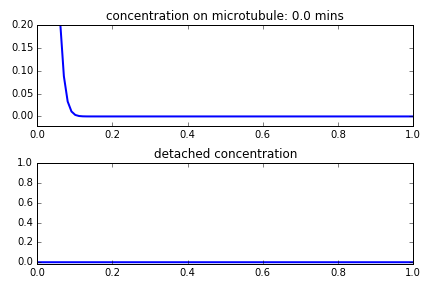
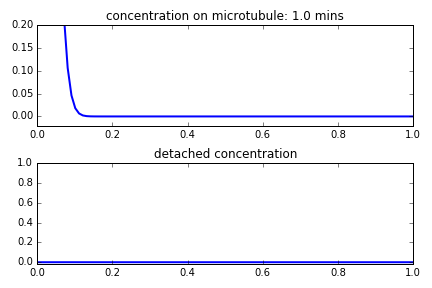
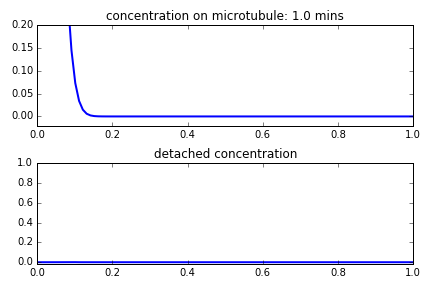
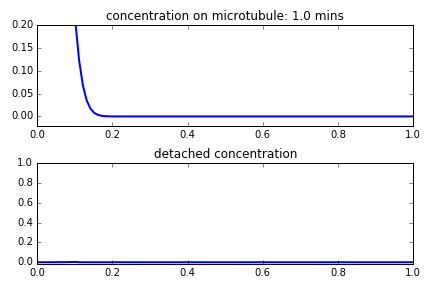
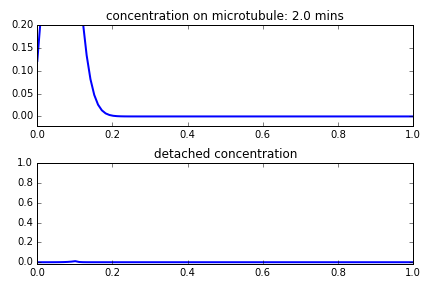
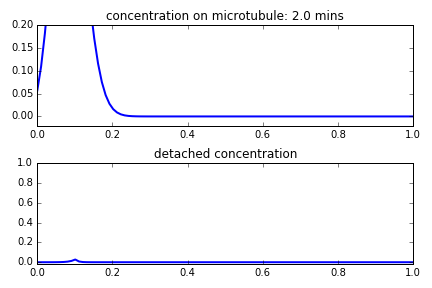
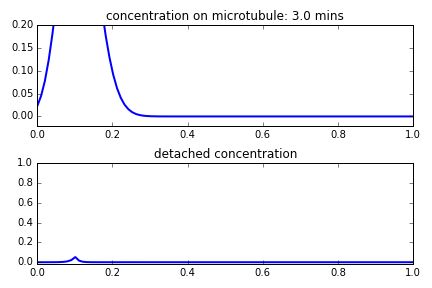
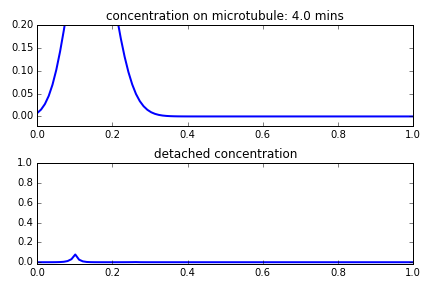
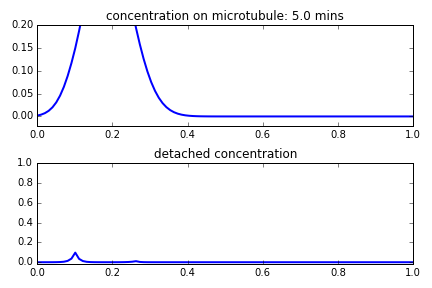
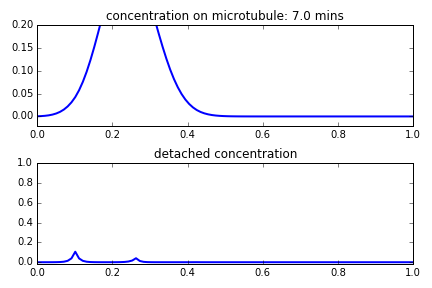
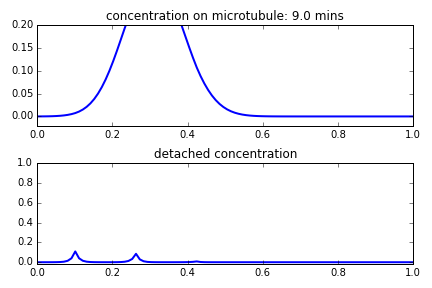
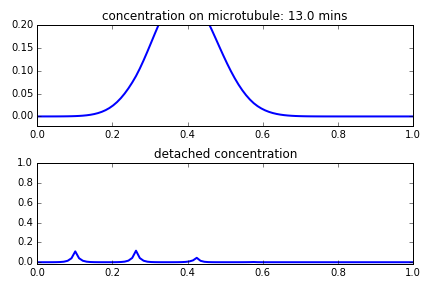
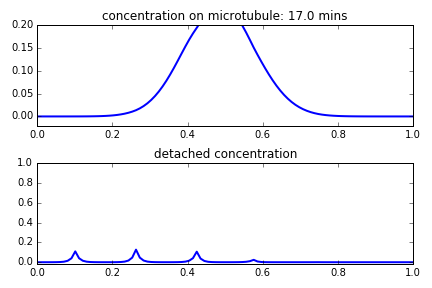
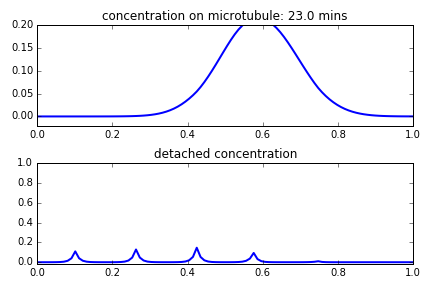
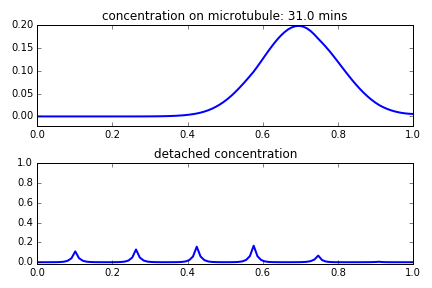
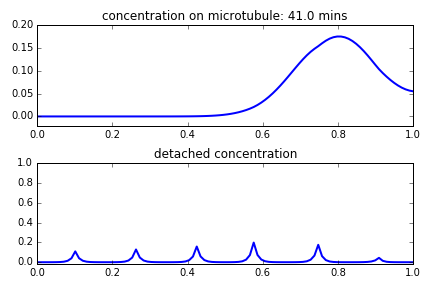
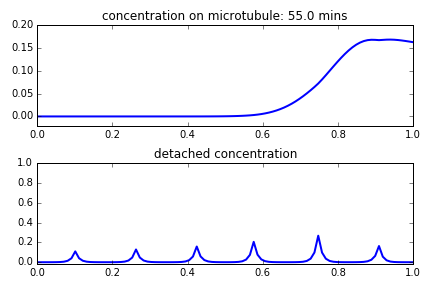
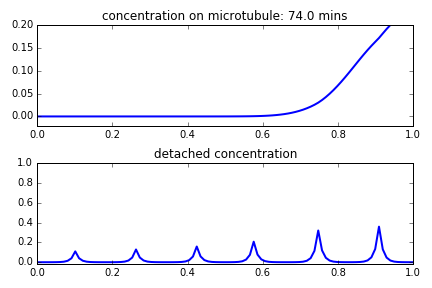
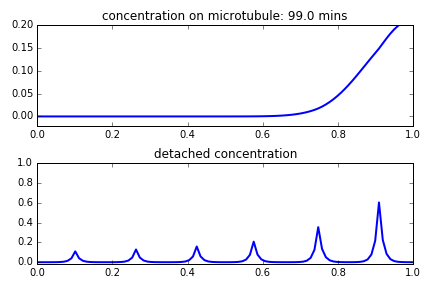
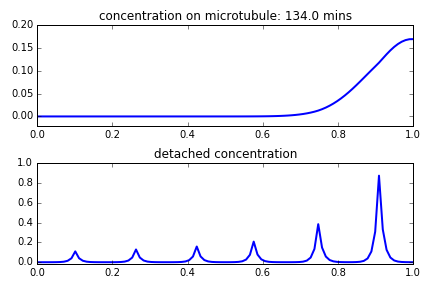
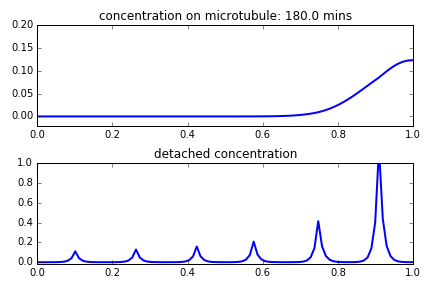
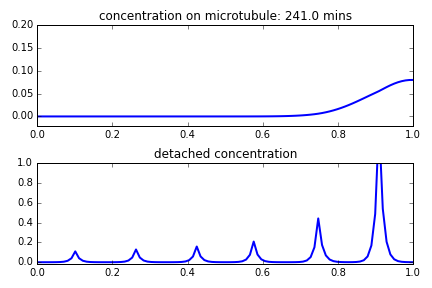
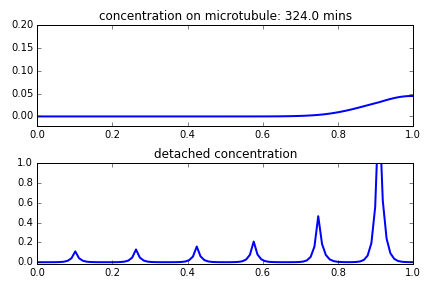
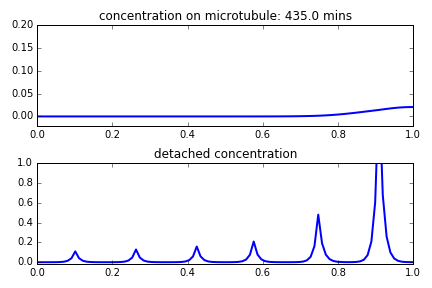
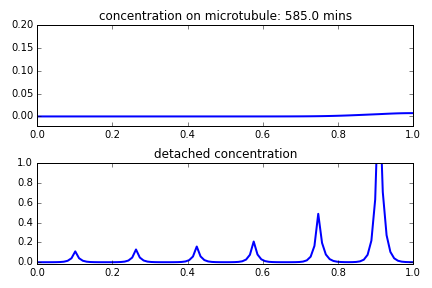
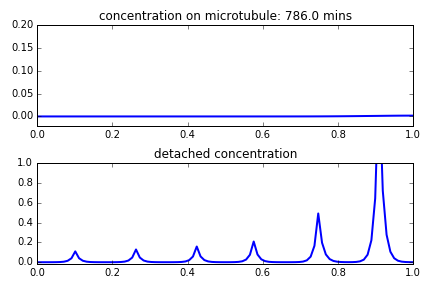
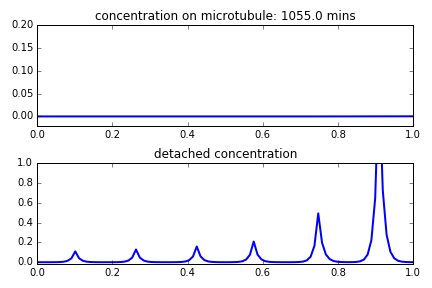
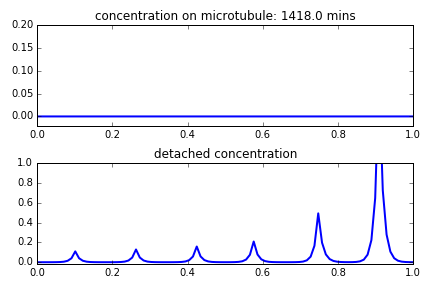
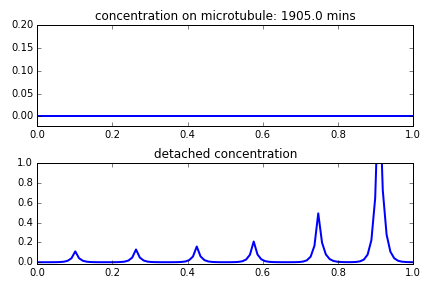
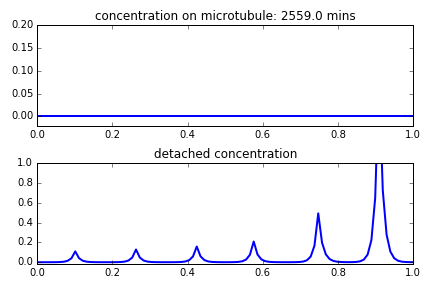
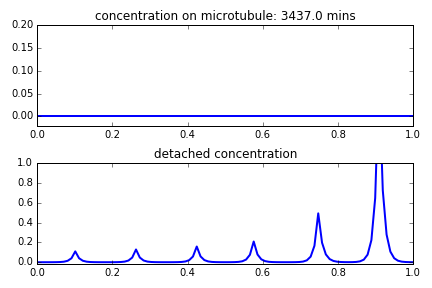
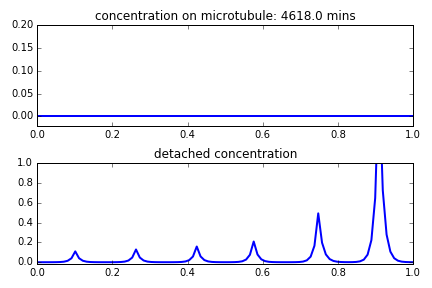
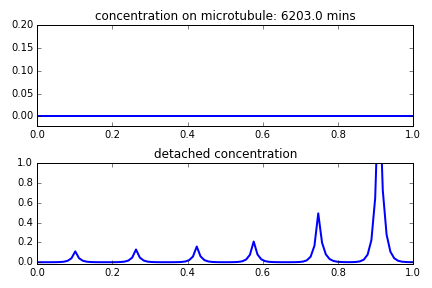
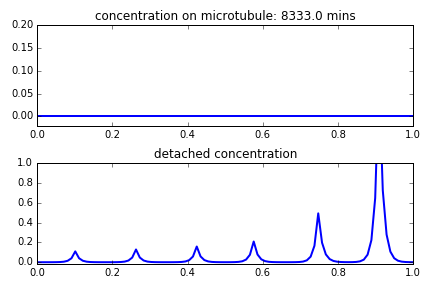

In [4]:
fig,animate,init,nt = run_sim(6,bias=0.032,timescale=2e-3)
ani3 = animation.FuncAnimation(fig, animate, init_func=init, frames=nt, interval=100)
ani3.save('03.mp4'); ani3

### Changing the number of stimulated synapses, while keeping the transport parameters constant, introduces new errors/biases in delivery

We tuned `bias` to fit a very particular synaptic stimulation pattern: six evenly spaced synapses. What happens when we change this stimulation pattern? If, for example, only 3 synapses are activated, the above model over-corrects and produces a distal bias.


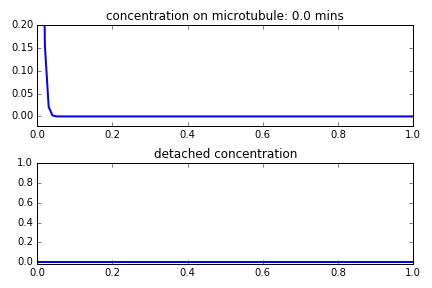
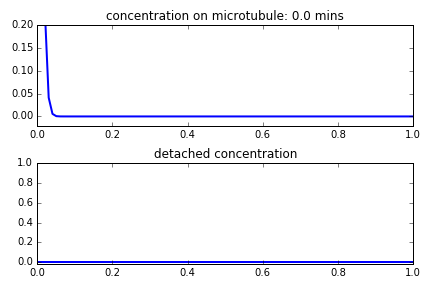
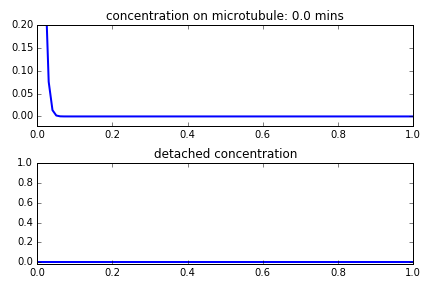
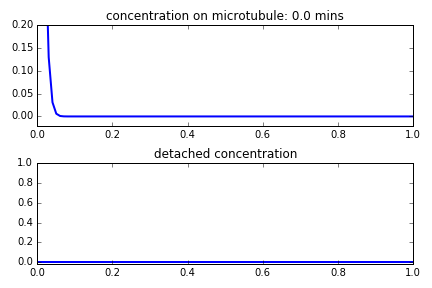
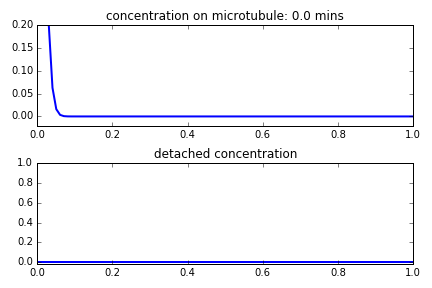
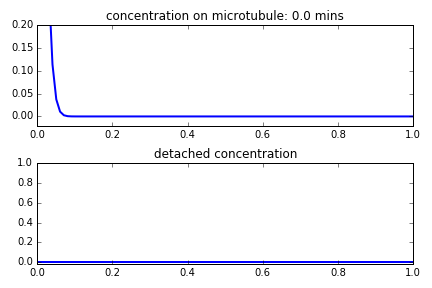
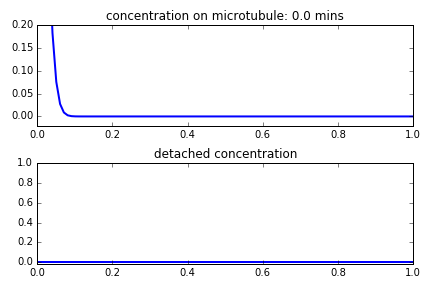
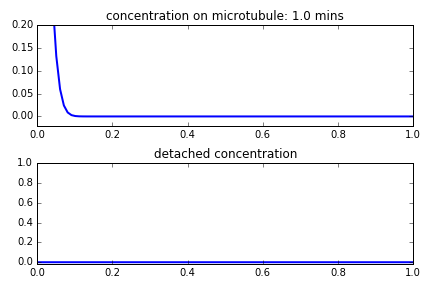
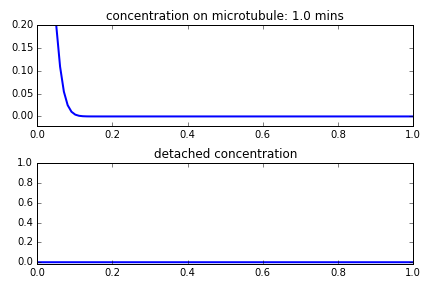
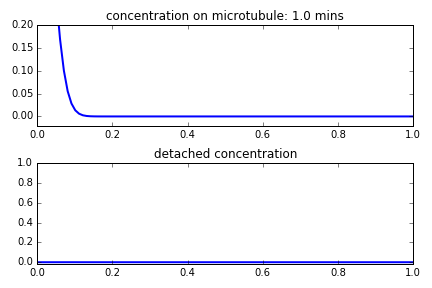
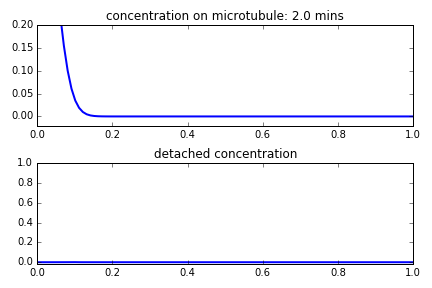
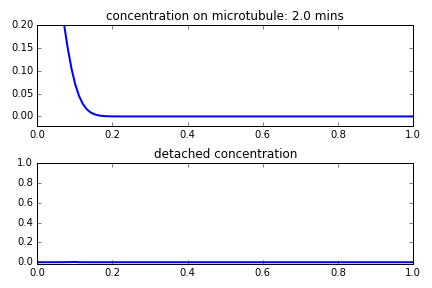
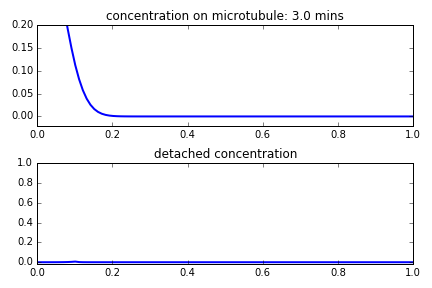
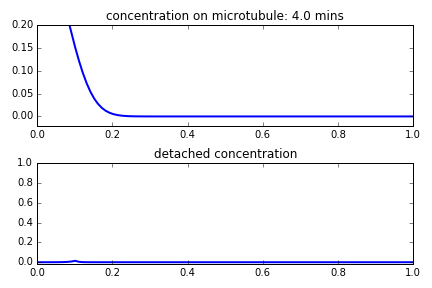
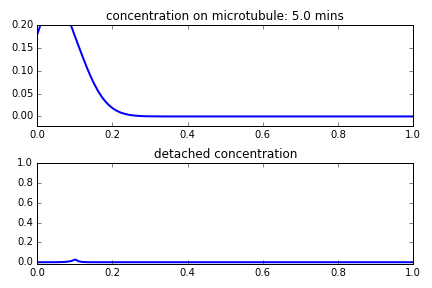
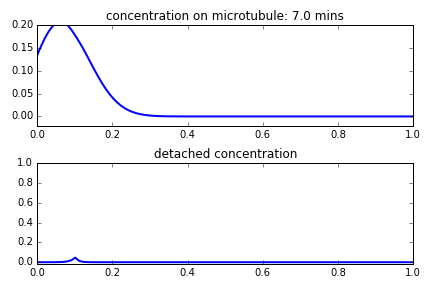
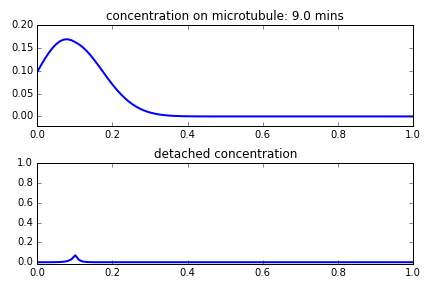
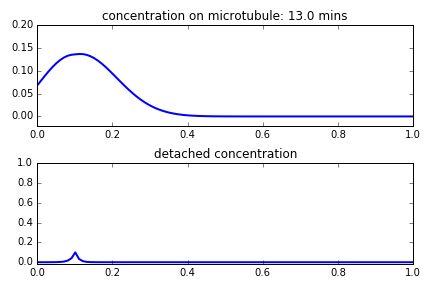
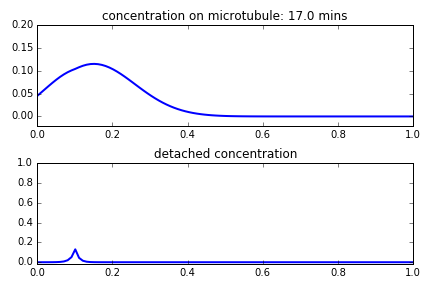
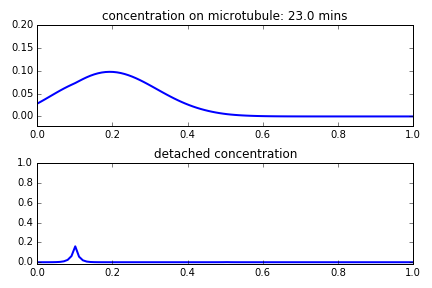
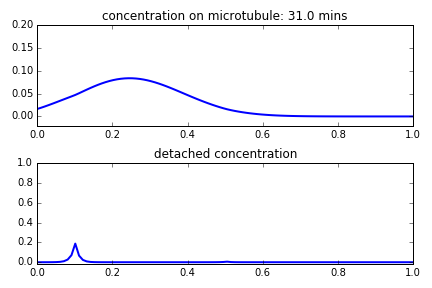
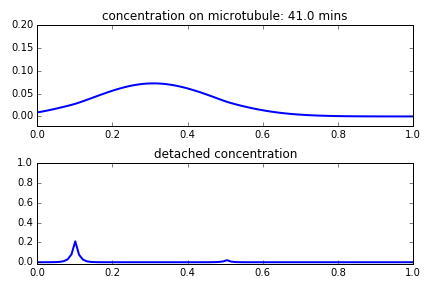
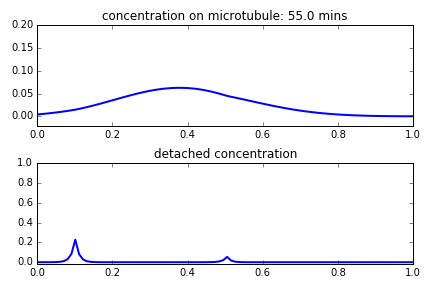
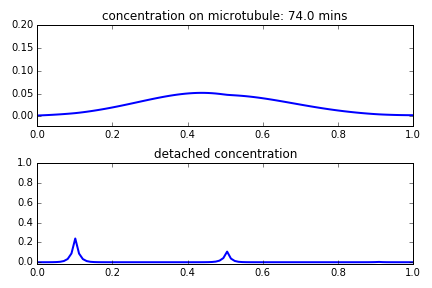
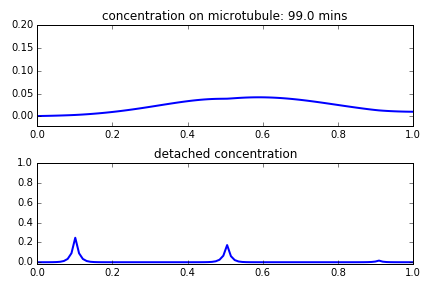
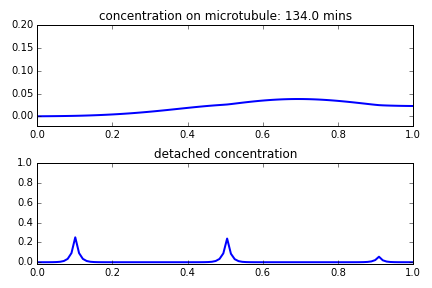
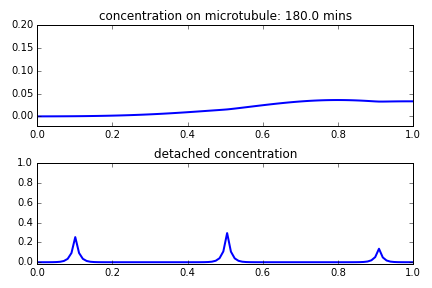
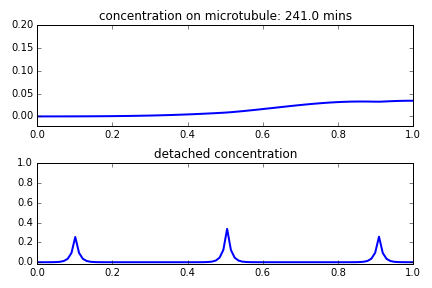
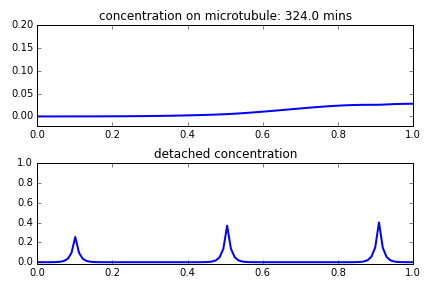
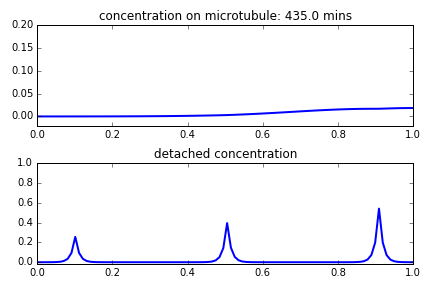
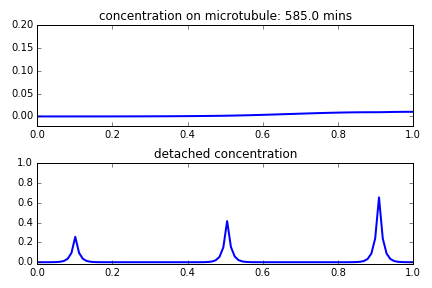
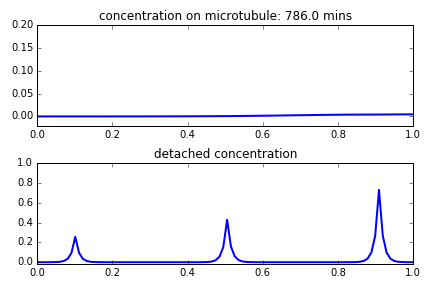
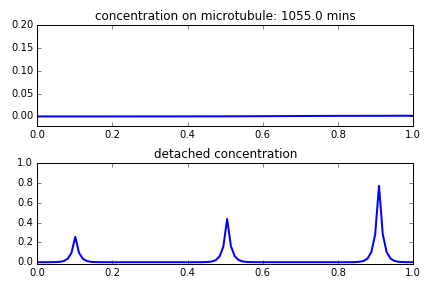
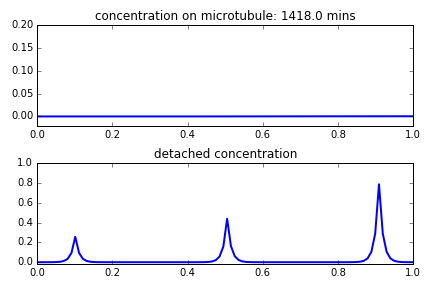
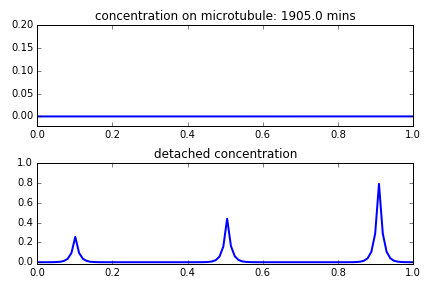
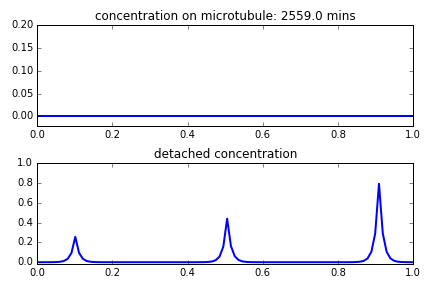
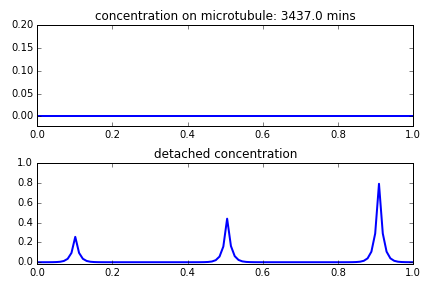
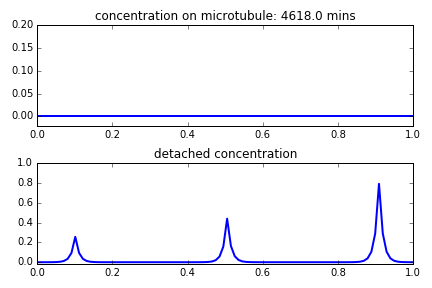
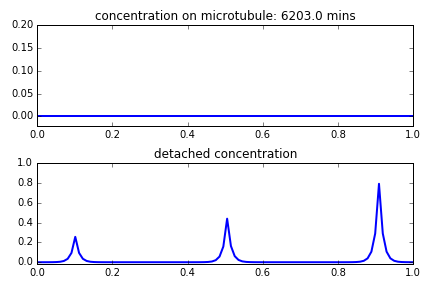
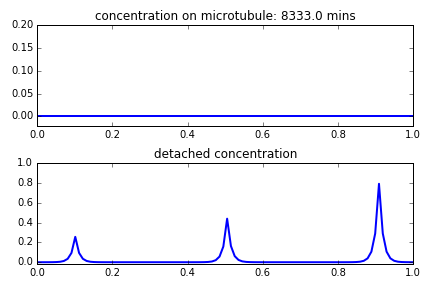

In [5]:
fig,animate,init,nt = run_sim(3,bias=6.4e-3,timescale=2e-3)
ani4 = animation.FuncAnimation(fig, animate, init_func=init, frames=nt, interval=100)
ani4.save('04.mp4'); ani4

### Steady-state plots for slow, flexible trafficking model

For all of the following plots, we consider three different stimulation patterns: (a) six evenly spaced synapses, (b) three evenly spaced synapses, and (c) six synapses, five of which are clustered on the proximal end of the cable. The "slow model" is able to precisely produce all of these distributions.

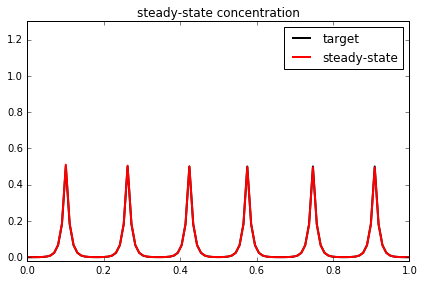

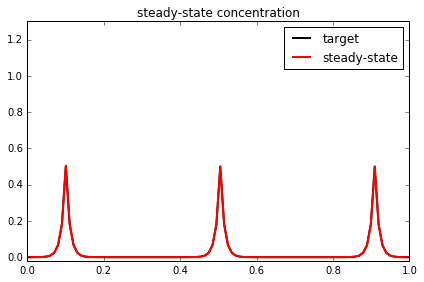

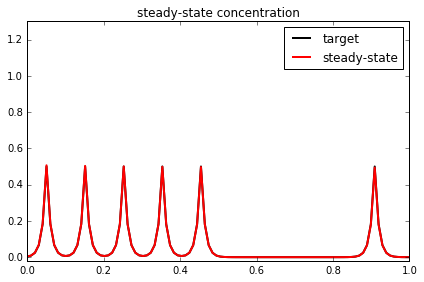

In [6]:
save_steady_state('A1',6,timescale=1e-5)
save_steady_state('A2',3,timescale=1e-5)
save_steady_state('A3',6,timescale=1e-5,syn_loc=[0.05,0.15,0.25,0.35,0.45,0.9])

### Steady-state plots for naïve, fast transport (leading to proximal bias)

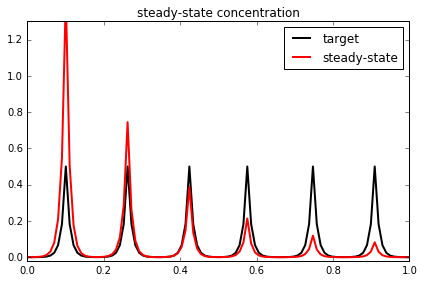

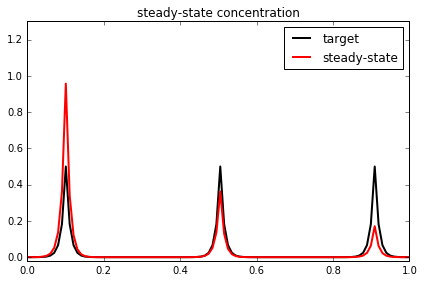

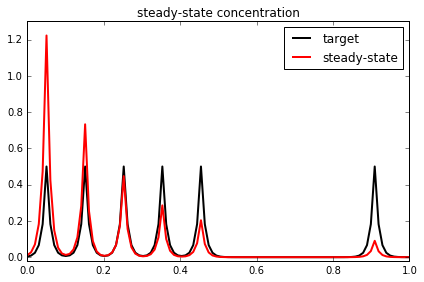

In [7]:
save_steady_state('B1',6,timescale=2e-3)
save_steady_state('B2',3,timescale=2e-3)
save_steady_state('B3',6,timescale=2e-3,syn_loc=[0.05,0.15,0.25,0.35,0.45,0.9])

### Steady-state plots for tuned model (fast, optimized for six evenly spaced synapses)

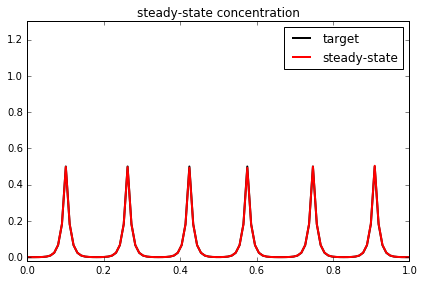

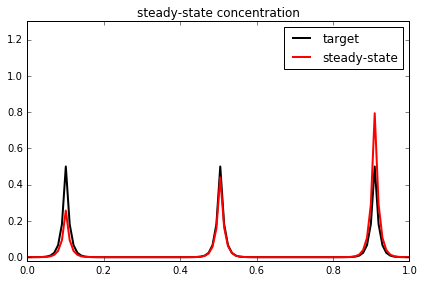

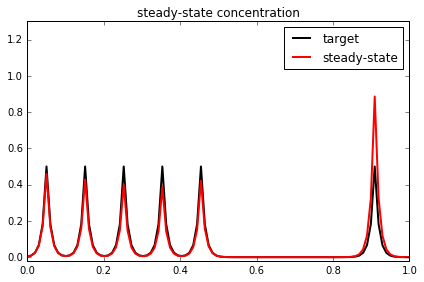

In [8]:
save_steady_state('C1',6,bias=6.4e-3,timescale=2e-3)
save_steady_state('C2',3,bias=6.4e-3,timescale=2e-3)
save_steady_state('C3',6,bias=6.4e-3,timescale=2e-3,syn_loc=[0.05,0.15,0.25,0.35,0.45,0.9])

### Tradeoff curves for error vs. speed for various levels of `bias` (velocities)

For these tradeoff curves, we roughly estimate the velocity and convergence time in measurable units. We make the following rough assumptions:

* We set each compartment to have a length of 8 microns. Since there are 100 compartments, this results in a 800 micron cable, which is roughly the length of an apical dendrite for a typical pyramidal neuron.
* We examined the effect of manipulating the velocity at the soma within experimentally measured ranges. We report these velocities in $\mu$m per minute; however, we simulate the model in units of seconds.
* The trafficking rates are constrained so that $a+b=0.5$, which means that the variance in position increases at a rate of 1/2 compartment size per second (4 $\mu m^2$ per second, see code/notebook for figure 1).
    * This has the following interpretation: if we start with a delta function of cargo as an initial condition, then after one second, the distribution of cargo should have a standard deviation of $\sqrt{4} = 2~\mu m$.
    * This is a conservative estimate, nearly an order of magnitude larger than the diffusion coefficient used in figure 1. Nevertheless, the tradeoff between speed and precision is severe.

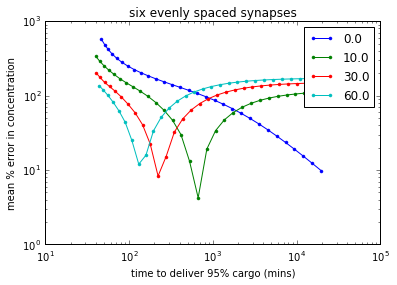

In [9]:
# Velocities at the soma (microns per minute)
velocities = [0.0,10.0,30.0,60.0]

# Compute bias terms
# /60 to convert seconds to minutes
# /cs the compartment size in microns
# /2 since velocity = a-b = (0.5+bias)-(0.5-bias) = 2*bias
bias_levels = [velocities[i]/60/cs/2 for i in range(len(velocities))]

plt.figure()
for bias in bias_levels:
    tau,err = calc_tradeoff_curve(6,bias=bias)
    plt.plot(tau/60,err,'.-')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e1,1e5])
plt.ylim([1e0,1e3])
plt.xlabel('time to deliver 95% cargo (mins)')
plt.ylabel('mean % error in concentration')
plt.title('six evenly spaced synapses')
plt.legend(velocities)
plt.savefig('D.svg')
plt.savefig('D.eps')

/home/alex/anaconda2/lib/python2.7/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


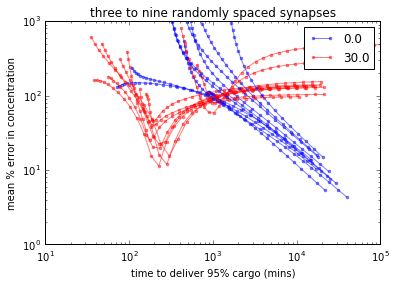

In [10]:
plt.figure()
for r in range(10):
    loc = np.random.uniform(0,1,np.random.randint(3,10))
    plt.gca().set_color_cycle(None)
    for bias,color in zip([bias_levels[i] for i in (0,2)],['b','r']):
        tau,err = calc_tradeoff_curve(len(loc),bias=bias,syn_loc=loc)
        plt.plot(tau/60,err,'.-',alpha=0.5,color=color)
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e1,1e5])
plt.ylim([1e0,1e3])
plt.xlabel('time to deliver 95% cargo (mins)')
plt.ylabel('mean % error in concentration')
plt.title('three to nine randomly spaced synapses')
plt.legend([velocities[i] for i in (0,2)])
plt.savefig('E.svg')
plt.savefig('E.eps')